In [1]:
!pip install imutils

In [2]:
!pip install tensorflow

In [3]:
import cv2
print(cv2.__version__)


4.12.0


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


[INFO] loading images...


C:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_36188\3937558546.py:63: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


[INFO] compiling model...
[INFO] training head...
Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.9060 - loss: 0.2759 - val_accuracy: 0.9762 - val_loss: 0.0912
Epoch 2/20


C:\Users\Administrator\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.9688 - loss: 0.1207 - val_accuracy: 0.9768 - val_loss: 0.0914
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.9789 - loss: 0.0885 - val_accuracy: 0.9821 - val_loss: 0.0582
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.9688 - loss: 0.0808 - val_accuracy: 0.9821 - val_loss: 0.0583
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9797 - loss: 0.0633 - val_accuracy: 0.9841 - val_loss: 0.0489
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.9688 - loss: 0.1052 - val_accuracy: 0.9841 - val_loss: 0.0489
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9829 - loss: 0.0569 - val_accuracy: 0.9815 - val_loss: 0.0539
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.9688 - loss: 0.0527 - val_accuracy: 0.9808 - val_loss: 0.0546
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9855 - loss: 0.0460 - val_accurac

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511

[INFO] saving mask detector model...


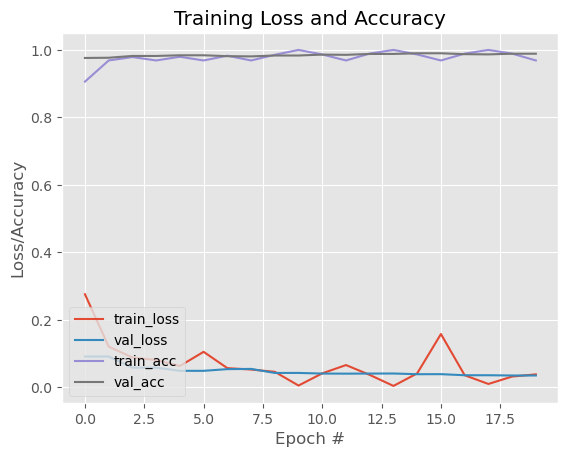

In [5]:
# Install missing package
# !pip install imutils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"dataset" #Dataset path
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

# one-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

trainX, testX, trainY, testY = train_test_split(
    data, labels, test_size=0.20, stratify=labels, random_state=42
)

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")

# Plot training graph
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()


In [4]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os


def detect_and_predict_mask(frame, faceNet, maskNet):

    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
                                 (104.0, 177.0, 123.0))

    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            face = frame[startY:endY, startX:endX]

            if face.size == 0:
                continue  # skip bad face crop

            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            faces.append(face)
            locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)


# LOAD MODELS
prototxtPath = r"deploy.prototxt"
weightsPath = r"res10_300x300_ssd_iter_140000.caffemodel"

faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = load_model(r"mask_detector.h5")


# START VIDEO STREAM
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()   
time.sleep(2.0)

while True:

    frame = vs.read()

    if frame is None:
        print("[WARNING] Frame is None — retrying...")
        continue

    try:
        frame = imutils.resize(frame, width=850)
    except:
        print("[ERROR] Could not resize frame")
        continue

    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 3)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()


[INFO] starting video stream...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━

Specific image

In [7]:
#specific image vala


# # import the necessary packages
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# import numpy as np
# import cv2
# import os

# def detect_and_predict_mask(image, faceNet, maskNet):
#     (h, w) = image.shape[:2]
#     blob = cv2.dnn.blobFromImage(image, 1.0, (224, 224),
#                                  (104.0, 177.0, 123.0))

#     faceNet.setInput(blob)
#     detections = faceNet.forward()

#     faces = []
#     locs = []
#     preds = []

#     for i in range(0, detections.shape[2]):
#         confidence = detections[0, 0, i, 2]

#         if confidence > 0.5:
#             box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
#             (startX, startY, endX, endY) = box.astype("int")

#             (startX, startY) = (max(0, startX), max(0, startY))
#             (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

#             face = image[startY:endY, startX:endX]
#             if face.size == 0:
#                 continue

#             face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
#             face = cv2.resize(face, (224, 224))
#             face = img_to_array(face)
#             face = preprocess_input(face)

#             faces.append(face)
#             locs.append((startX, startY, endX, endY))

#     if len(faces) > 0:
#         faces = np.array(faces, dtype="float32")
#         preds = maskNet.predict(faces, batch_size=32)

#     return (locs, preds)

# # ---------------- LOAD MODELS ----------------
# prototxtPath = r"C:\Users\Administrator\Desktop\krish_P_Detection_system\YOLO_perfect\deploy.prototxt"
# weightsPath = r"C:\Users\Administrator\Desktop\krish_P_Detection_system\YOLO_perfect\res10_300x300_ssd_iter_140000.caffemodel"
# faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# maskNet = load_model(r"C:\Users\Administrator\Desktop\krish_P_Detection_system\YOLO_perfect\mask_detector.h5")

# # ---------------- LOAD IMAGE ----------------
# image_path = r"C:\Users\Administrator\Pictures\Camera Roll\WIN_20241209_19_14_42_Pro.jpg"
# image = cv2.imread(image_path)

# if image is None:
#     raise ValueError(f"Image not found at path: {image_path}")

# # ---------------- DETECTION ----------------
# (locs, preds) = detect_and_predict_mask(image, faceNet, maskNet)

# # ---------------- DRAW RESULTS ----------------
# for (box, pred) in zip(locs, preds):
#     (startX, startY, endX, endY) = box
#     (mask, withoutMask) = pred

#     label = "Mask" if mask > withoutMask else "No Mask"
#     color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
#     label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

#     cv2.putText(image, label, (startX, startY - 10),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
#     cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# # ---------------- DISPLAY BIGGER IMAGE ----------------
# cv2.namedWindow("Mask Detection", cv2.WINDOW_NORMAL)   # make window resizable
# cv2.resizeWindow("Mask Detection", 700, 500)          # set bigger window size

# # Optional: scale image proportionally (uncomment if needed)
# # scale_percent = 150
# # width = int(image.shape[1] * scale_percent / 100)
# # height = int(image.shape[0] * scale_percent / 100)
# # dim = (width, height)
# # image = cv2.resize(image, dim, interpolation=cv2.INTER_LINEAR)

# cv2.imshow("Mask Detection", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


below is frontend using tkinter

In [ ]:
# Face Mask Detection GUI using Tkinter (Final Fixed Version)

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import tkinter as tk
from tkinter import filedialog, messagebox


# ---------------- Utility Functions ----------------
def resize_to_fit(frame, max_width=900, max_height=700):
    """Resize image while maintaining aspect ratio."""
    h, w = frame.shape[:2]
    scale = min(max_width / w, max_height / h)
    if scale < 1:
        frame = cv2.resize(frame, (int(w * scale), int(h * scale)))
    return frame


def detect_and_predict_mask(frame, faceNet, maskNet):
    """Detect faces and predict mask status."""
    (h, w) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces, locs, preds = [], [], []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence < 0.5:
            continue

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        startX, startY = max(0, startX), max(0, startY)
        endX, endY = min(w - 1, endX), min(h - 1, endY)

        face = frame[startY:endY, startX:endX]

        if face.size == 0:
            continue

        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)

        faces.append(face)
        locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        preds = maskNet.predict(np.array(faces, dtype="float32"))

    return locs, preds


def draw_results(frame, locs, preds):
    """Draw bounding boxes and labels."""
    for (box, pred) in zip(locs, preds):
        (mask, withoutMask) = pred
        (startX, startY, endX, endY) = box

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = f"{label}: {max(mask, withoutMask) * 100:.2f}%"

        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    return frame


# ---------------- Load Models ----------------
try:
    faceNet = cv2.dnn.readNet(
        r"deploy.prototxt",
        r"res10_300x300_ssd_iter_140000.caffemodel"
    )

    maskNet = load_model(
        r"mask_detector.h5"
    )

except Exception as e:
    messagebox.showerror("Model Loading Error", f"Error loading models:\n{e}")
    exit()


# ---------------- Close All OpenCV Windows Safely ----------------
def close_all_cv():
    try:
        cv2.destroyAllWindows()
        cv2.waitKey(1)
    except:
        pass


# ---------------- GUI Functions ----------------
def upload_image():
    path = filedialog.askopenfilename()
    if not path:
        return

    image = cv2.imread(path)
    if image is None:
        messagebox.showerror("Error", "Unable to load this image file.")
        return

    locs, preds = detect_and_predict_mask(image, faceNet, maskNet)
    output = draw_results(image.copy(), locs, preds)
    output = resize_to_fit(output)

    cv2.imshow("Image Detection Result", output)
    cv2.waitKey(0)
    close_all_cv()


def upload_video():
    path = filedialog.askopenfilename()
    if not path:
        return

    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        messagebox.showerror("Error", "Cannot open video file.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        locs, preds = detect_and_predict_mask(frame, faceNet, maskNet)
        frame = draw_results(frame, locs, preds)
        frame = resize_to_fit(frame)

        cv2.imshow("Video Detection", frame)

        if cv2.waitKey(1) in [27, ord('q')]:  # ESC or Q
            break

    cap.release()
    close_all_cv()


def start_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        messagebox.showerror("Error", "Webcam not detected.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        locs, preds = detect_and_predict_mask(frame, faceNet, maskNet)
        frame = draw_results(frame, locs, preds)
        frame = resize_to_fit(frame)

        cv2.imshow("Webcam Mask Detection", frame)

        if cv2.waitKey(1) in [27, ord('q')]:
            break

    cap.release()
    close_all_cv()


def safe_exit():
    close_all_cv()
    root.quit()
    root.destroy()


# ---------------- GUI Layout ----------------
root = tk.Tk()
root.title("Face Mask Detection System")
root.geometry("420x420")
root.configure(bg="skyblue")

tk.Label(root, text="Face Mask Detection System",
         font=("Arial", 18, "bold"), bg="skyblue").pack(pady=20)

tk.Button(root, text="Upload Image", command=upload_image,
          font=("Arial", 14), bg="green", fg="white", width=22).pack(pady=10)

tk.Button(root, text="Upload Video", command=upload_video,
          font=("Arial", 14), bg="blue", fg="white", width=22).pack(pady=10)

tk.Button(root, text="Start Webcam", command=start_webcam,
          font=("Arial", 14), bg="purple", fg="white", width=22).pack(pady=10)

tk.Button(root, text="Exit", command=safe_exit,
          font=("Arial", 14), bg="red", fg="white", width=22).pack(pady=20)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━